# <center>Network Science</center>

## <hr /> <center>Project 1</center>

## <center> Structural Analysis and Visualization of Personal Social Network <center>

### <center>Student:  *Marina Ananyeva*</center>

<hr /> 

####  Essential Requirements
**Introduction** <br \>
This document lists minimum requirements to the content of presentation of mid-term exam. To recall the exam procedure: <br \>
* Presentation in English, both written and oral <br \>
* Time limit - 5-7 mins <br \>
* .pdf file <br \>
* You are encourages to discuss presented results<br \>
* Source code submission and its inclusion (with comments) to the report<br \>
<br \> 
**1 Your Network Summary **<br \> 
* Network source and preprocessing <br \>
* Node/Edge attributes<br \>
* Size, Order <br \>
* *Gorgeous* network layout. Try to show that your network has some structure, play with node sizes and colors, scaling parameters, tools like Gephi may be useful here<br \>
* Degree distribution, Diameter, Clustering Coefficient <br \>
<br \> 
**2 Structural Analysis **<br \> 
* Degree/Closeness/Betweenness centralities. Top nodes interpretation<br \> 
* PageRank. Comparison with centralities<br \> 
* Assortative Mixing according to node attributes <br \> 
* Node sctructural equivalence/similarity<br \> 
* The closest random graph model similar to your SN<br \> 
<br \> 
**3 Community Detection **<br \> 
* Clique search <br \> 
* Best results of various community detection algorithms, both in terms of interpretation and some quality criterion. Since Networkx has no community detection algorithms, use additional modules e.g. igraph, communities, graph-tool, etc. <br \> 
* Use and implement incremental algorithms presented during classes<br \> 
* The results should be visible on the network layout or adjacency matrix picture<br \> 
<hr /> 

## 1. Network Summary 

### Network Source and preprocessing <br \> 

For the purposes of this project it was decided to analyze my social network in Vkontakte, which represents my connections with friends, colleagues and relatives.  <br \>
* **Source**: https://vk.com <br \>

Data was accessed using VK API requests. The following application was registered https://vk.com/app5954764 in order to get access_token if required. <br \>
The following notes should be taken into account: the graph is undirected and unweighted. The network is egocentric as far as I excluded myself from the data. <br\ >
* **Attributes** of users:
* First name + last name
* Sex
* Birthday
* City
* Number of friends (by categories) <br \>

## Download data using VK API

In [1]:
# Import of libraries

import networkx as nx
import time
import requests
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define a function that returns list of friends

def ids_friends(user_ids):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}'
    json_response = requests.get(friends_url.format(user_ids)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list()
    return json_response[u'response']

In [5]:
# Define a range of ages

def age_range(date):
    beg = date.find('.')
    ind = date.find('.', beg + 1)
    if ind == -1:
        return 'Nothing'
    else:
        year = int(date[(ind + 1):])
        if year > 2000 and year <= 2005:
            return '2000-2005'
        if year > 1995 and year <= 2000:
            return '1995-2000'
        if year > 1985 and year <= 1995:
            return '1985-1995'
        if year > 1970 and year <= 1980:
            return '1945-1985'
        else:
            return 'Nothing'

In [6]:
# Define range of number of contacts 

def friends_range(friends_number):
    if friends_number > 0 and friends_number <= 100:
        return '0-100'
    elif friends_number > 100 and friends_number <= 200:
        return '100-200'
    elif friends_number > 200 and friends_number <= 300:
        return '200-300'
    elif friends_number > 300 and friends_number <= 500:
        return '300-500'
    elif friends_number > 500:
        return '500-10000'
    else:
        return 'None'

In [19]:
# Decode city numbers into names

def city2name(ids):
    url = 'https://api.vk.com/method/database.getCitiesById?city_ids={}&lang=en'
    json_response = requests.get(url.format(ids)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list()
    names = {}
    for city in json_response[u'response']:
        names[city['cid']] = city['name']
    return names

In [8]:
# Get list of contact's information 

def get_info(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&fields=first_name,city,sex,bdate&lang=en'
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('Error'):
        print(json_response.get('Error'))
        return list(), list(), list(), list()
    
    names =   {}
    gender =   {}
    cities =  {}
    bdays =  {}
    
    for friend in json_response[u'response']:
        names[friend['user_id']] = friend['first_name'] + ' ' + friend['last_name']
        gender[friend['user_id']] = friend['sex']
        if any([x == 'city' for x in list(friend.keys())]):
            cities[friend['user_id']] = friend['city']
        else:
            cities[friend['user_id']] = 'NA'
        if any([x == 'bdate' for x in list(friend.keys())]):
            bdays[friend['user_id']] = age_range(friend['bdate'])
        else:
            bdays[friend['user_id']] = 'NA'
            
    return names, gender, cities, bdays

In [15]:
# Create dictionary for graph
graph = {}

# Personal ID in vk.com 
my_id = 6395751
friend_ids = ids_friends(my_id)
names, gender, cities, bdays = get_info(my_id)
temp = []
for friend_id in friend_ids:
    if not {names[friend_id]}.issubset(set(graph.keys())):
        fr_names, _, _, _ = get_info(friend_id)
        if fr_names != []:
            graph[names[friend_id]] = {}
            graph[names[friend_id]]['friends'] = list(fr_names.values())
            graph[names[friend_id]]['sex']     = gender[friend_id]
            graph[names[friend_id]]['cities']  = cities[friend_id]
            temp.append(cities[friend_id])
            graph[names[friend_id]]['bdays']  = bdays[friend_id]
            graph[names[friend_id]]['num_friends'] = friends_range(len(graph[names[friend_id]]['friends']))
            print ("Friend's id: ", friend_id )

Friend's id:  56572
Friend's id:  97723
Friend's id:  108149
Friend's id:  122703
Friend's id:  136773
Friend's id:  152726
Friend's id:  157555
Friend's id:  172893
Friend's id:  320259
Friend's id:  368790
Friend's id:  487075
Friend's id:  577425
Friend's id:  597156
Friend's id:  599389
Friend's id:  761427
Friend's id:  762901
Friend's id:  763357
Friend's id:  865250
Friend's id:  900315
Friend's id:  931105
Friend's id:  952647
Friend's id:  1028119
Friend's id:  1059322
Friend's id:  1060562
Friend's id:  1085559
Friend's id:  1213932
Friend's id:  1249364
Friend's id:  1310930
Friend's id:  1359240
Friend's id:  1361774
Friend's id:  1376875
Friend's id:  1386997
Friend's id:  1435609
Friend's id:  1506248
Friend's id:  1521684
Friend's id:  1596246
Friend's id:  1623228
Friend's id:  1642210
Friend's id:  1720064
Friend's id:  1765040
Friend's id:  1861814
Friend's id:  2001394
Friend's id:  2060382
Friend's id:  2118571
Friend's id:  2133330
Friend's id:  2140262
Friend's id

In [20]:
# List of cities in dataset

delimiter = ''
for x in set(temp):
    delimiter += str(x) + ','
city_name = city2name(delimiter)
city_name

{1: 'Moscow',
 2: 'Saint Petersburg',
 10: 'Volgograd',
 18: 'Almetyevsk',
 23: 'Astrakhan',
 38: 'Vladikavkaz',
 39: 'Vladimir',
 42: 'Voronezh',
 49: 'Yekaterinburg',
 60: 'Kazan',
 80: 'Lyubertsy',
 95: 'Nizhny Novgorod',
 99: 'Novosibirsk',
 104: 'Omsk',
 110: 'Perm',
 117: 'Ramenskoe',
 144: 'Tomsk',
 151: 'Ufa',
 153: 'Khabarovsk',
 161: 'Chita',
 167: 'Yuzhno-Sakhalinsk',
 175: 'Apatity',
 270: 'Podolsk',
 295: 'London',
 314: 'Kyiv',
 378: 'New York City',
 598: 'Dedovsk',
 625: 'Dmitrov',
 735: 'Svetlograd',
 1386: 'Sergiev Posad',
 20860: 'Bremen',
 1057095: 'Dubki',
 1516109: 'Montego Bay',
 1925340: 'Rīga',
 1951986: 'München',
 1958117: 'Cairo',
 2210985: 'Stockholm',
 4967915: 'Oxford'}

In [21]:
for friend_id in friend_ids:
    fr_names, _, _, _ = get_info(friend_id)
    if fr_names != [] and (type(graph[names[friend_id]]['cities']) == int):
        if any([x == graph[names[friend_id]]['cities'] for x in list(city_name.keys())]):
            graph[names[friend_id]]['cities'] = city_name[graph[names[friend_id]]['cities']]
        else:
            graph[names[friend_id]]['cities'] = 'NA'

In [23]:
# Create undirected graph

G = nx.Graph(directed=False)

# Connect friends with each other
for i in list(graph.keys()):
    G.add_node(i)
    for j in graph[i]['friends']:
        if i != j and i in list(names.values()) and j in list(names.values()):
            G.add_edge(i, j)
    G.node[i]['sex'] = graph[i]['sex']
    G.node[i]['cities'] = graph[i]['cities']
    G.node[i]['bdays'] = graph[i]['bdays']
    G.node[i]['numf'] = graph[i]['num_friends']

In [24]:
for i in list(graph.keys()):
    print(G.node[i])

{'sex': 2, 'cities': 'Moscow', 'bdays': 'Nothing', 'numf': '500-10000'}
{'sex': 2, 'cities': 'Moscow', 'bdays': 'Nothing', 'numf': '500-10000'}
{'sex': 2, 'cities': 'Saint Petersburg', 'bdays': 'Nothing', 'numf': '500-10000'}
{'sex': 1, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '100-200'}
{'sex': 1, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '200-300'}
{'sex': 2, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '500-10000'}
{'sex': 1, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '500-10000'}
{'sex': 1, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '200-300'}
{'sex': 1, 'cities': 'München', 'bdays': 'Nothing', 'numf': '300-500'}
{'sex': 1, 'cities': 'Saint Petersburg', 'bdays': 'Nothing', 'numf': '300-500'}
{'sex': 1, 'cities': 'Moscow', 'bdays': 'Nothing', 'numf': '300-500'}
{'sex': 2, 'cities': 'Moscow', 'bdays': '1985-1995', 'numf': '500-10000'}
{'sex': 1, 'cities': 'Saint Petersburg', 'bdays': '1985-1995', 'numf': '500-10000'}
{'sex': 1, 'cities': 'Moscow', 

In [25]:
# Save dataset
nx.write_gml(G, "social_network.gml")

## Network Summary

In [26]:
import numpy as np
import scipy.spatial as spt
import scipy.stats
import scipy
from scipy.optimize import minimize
from scipy.stats import ks_2samp
from sklearn import grid_search

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [27]:
G = nx.read_gml('social_network.gml')

In [28]:
print('Order (number of nodes):', nx.number_of_nodes(G))
print('Size (number of edges):', nx.number_of_edges(G))
print('Number of connected components:', nx.number_connected_components(G))

Order (number of nodes): 341
Size (number of edges): 3302
Number of connected components: 9


In [32]:
# Get sorted connected components of graph
# Calculate diameter and radius of the largest component
sorted_cc = sorted(nx.connected_components(G), key = len, reverse=True)
sub_graph = G.subgraph(sorted_cc[0])
print('Radius:', nx.radius(sub_graph))
print('Diameter:', nx.diameter(sub_graph))

Radius: 4
Diameter: 7


In [30]:
print('Order (number of nodes) of the largest component:', nx.number_of_nodes(sub_graph))
print('Size (number of edges) of the largest component:', nx.number_of_edges(sub_graph))

Order (number of nodes) of the largest component: 333
Size (number of edges) of the largest component: 3302


The number of friends in the largest component of this network shows that the graph is almost connected. It can be explained by highly possible connections among my friends, colleagues and relatives. Most of them know each other or have mutual friends. The greatest part of my 341 friends were proceeding their secondary or higher education in Moscow and they keep living and working here. As far as I was born in Moscow, most of my friends from scphool also entered the same sports club and the university (HSE). In addition, a lot of my friends from HSE and MIPT universities are affiliated to the same travel club 'I like trip' at HSE. For this reason, many friends of mine know each other and the network's greatest distance between any two persons is quite low. 
As we may observe, the largest component contains almost all nodes of the graph. If we have excluded 8 persons from the dataset, we could say, that that the graph is connected. I decided to focus just on the largest component, rather than the whole network, so I can use the characteristics of complete subgraph.

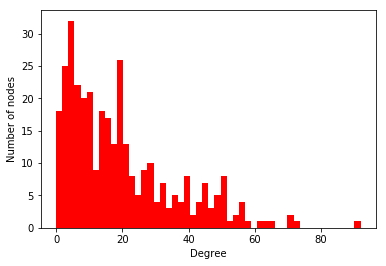

In [44]:
# Degree distribution
k = G.degree()
k = np.array(list(k.values()))
n, bins, patches = plt.hist(k, bins = 50, facecolor='r')
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

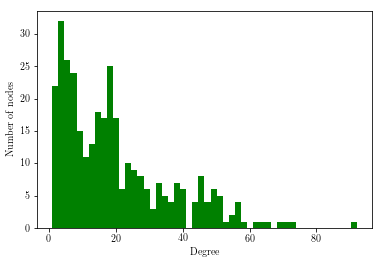

In [51]:
# Degree distribution of the largest component (subgraph) evidently looks almost the same
k = sub_graph.degree()
k = np.array(list(k.values()))
n, bins, patches = plt.hist(k, bins = 50, facecolor='g')
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

In [62]:
print('Max value of node degree = {}'.format(np.max(nodes_degree)))
print('Mean value of node degree = {}'.format(np.mean(nodes_degree)))

Max value of node degree = 92
Mean value of node degree = 19.366568914956012


Degree distribution of tis network does not exactly old Power Law, but it may look similar to it wit te increase of number of observations. 

array([ 0.11618742, -0.277465  ])

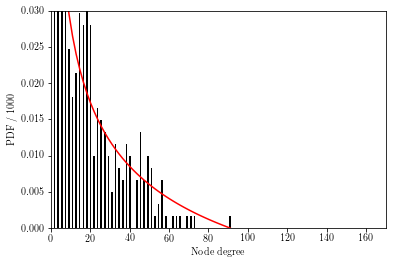

In [52]:
# Plot node degree to PDF

def power_law(x, a, b):
    return a * x ** b

def loss(x):
    minimum = np.min(power_law(centerA, x[0], x[1]))
    return np.mean(np.abs(power_law(centerA, x[0], x[1]) - minimum- histA))

a_1 = 0.08
b_1 = -0.2
histA, binsA = np.histogram(k, bins = 50, density = True)
centerA = (binsA[:-1] + binsA[1:]) / 2
res = minimize(loss, [a_1, b_1])
a_1 = res.x[0]
b_1 = res.x[1]
minimumA = np.min(power_law(centerA, a_1, b_1))

fig = plt.figure()
plt.bar(centerA, histA, align='center', color = 'k')
plt.plot(centerA, power_law(centerA, a_1, b_1) - minimumA, color = 'r')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel('Node degree')
plt.ylabel('PDF / 1000')
plt.xlim(0,170)
plt.ylim(0,0.03)
ax = fig.add_subplot(111)
a_1 = round(a_1, 2)
b_1 = round(b_1, 2)
plt.savefig('node_degree.png', dpi = 350)
res.x

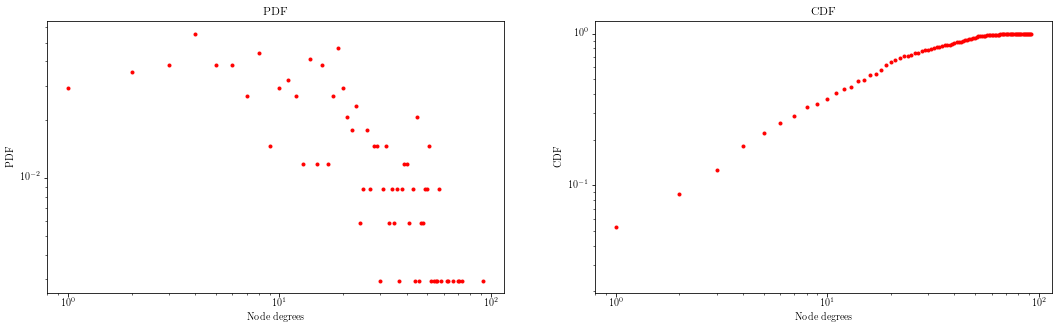

In [56]:
# Plot PDF and CDF 

nodes_degree = list(G.degree().values())
# Find number of nodes with k links
nodes_number = np.bincount(nodes_degree)
pdf = nodes_number.astype(float) / G.number_of_nodes()
cdf = np.cumsum(pdf)
plt.figure(figsize=(18,5))

plt.subplot(1,2,2)
plt.loglog(np.arange(0, len(cdf)), cdf, 'r.')
plt.title('CDF')
plt.xlabel('Node degrees')
plt.ylabel('CDF')

plt.subplot(1,2,1)
plt.loglog(np.arange(0, len(pdf)), pdf, 'r.')
plt.title('PDF')
plt.xlabel('Node degrees')
plt.ylabel('PDF')

As a result of additional analysis, from the plots above we can see that network tends to be a heavy-tailed distribution, that in general corresponds to power law.

The additional statistics from Gephi for the whole graph are the following:
* **The average path length** = 2.9
* **The average clustering coefficient** = 0.501
* **Density** = 0.057 <br\>
The density as a low value, but at the same time the graph is almost complete. The clustering coefficient is moderate and any two persons from this network are on average 3 steps away from each other. This subgraph is a quite dense community structure and recalls a small world. 

## Network Visualization

As it was already mentioned, I used Gephi application in order to visualize the dataset. Down below are plotted different representations, all of them present the same network.

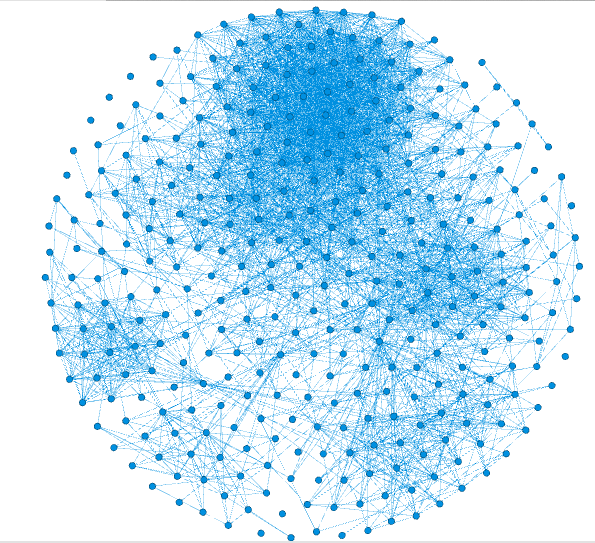

In [21]:
# Fruchterman Reingold layout
from IPython.display import Image
Image ('Fruchterman_Reingold.png')

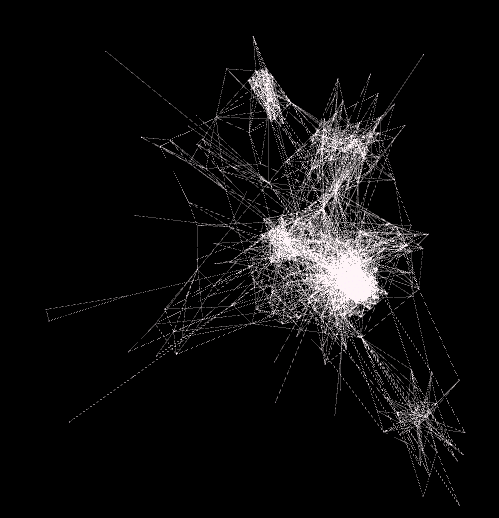

In [17]:
#Yifan Hu layout
from IPython.display import Image
Image ('futuristic_style.png')

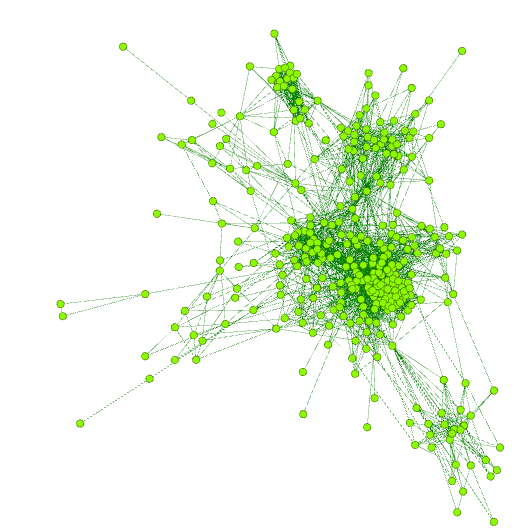

In [18]:
# Also Yifun Hu, but colourful one
from IPython.display import Image
Image ('green_and_yellow.png')

In the last two graphs the nodes' size and colour present their degree (number of its nearest neighbours).

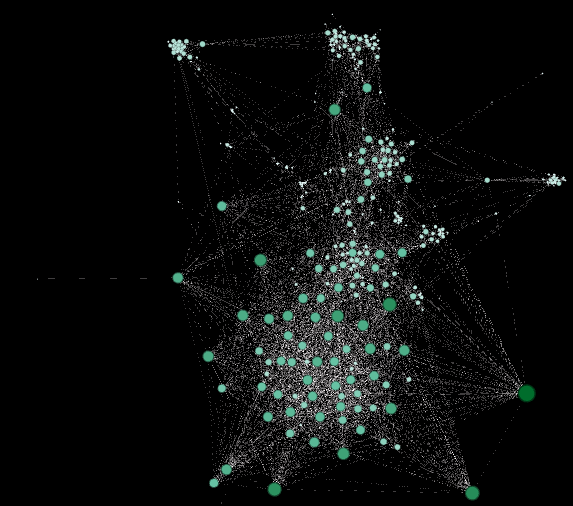

In [19]:
#ForceAtlas2
# With LingLog and Dissuade hubs modes on
from IPython.display import Image
Image ('ForceAtlas2.png')

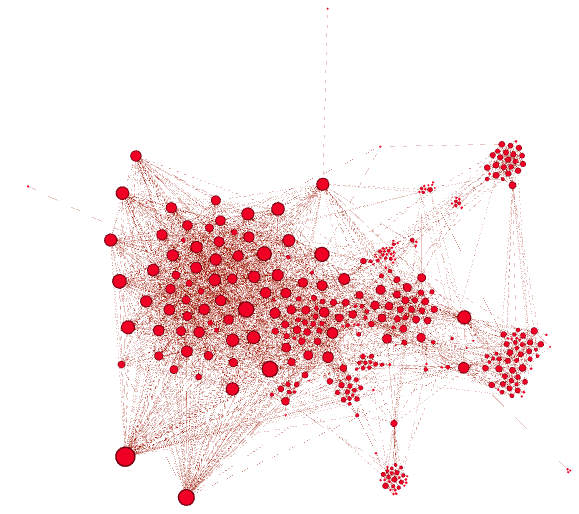

In [22]:
#ForceAtlas2
# With LingLog mode on
from IPython.display import Image
Image ('ForceAtlas2red.png')

## 2. Structural analysis 

### Centrality metrics

If we try to interpret the degree, betweenness and closeness centrality metrics, we may say the following:
* High **degree centrality ** identifies those guys who share with me a lot of friends. <br \>
* **Closeness centrality** shows the closest friends who know my other friends indirectly (the length of the shortest paths between the node and all other nodes in the graph). <br \>
* **Betwenness centrality ** helps to see those who connect diverse groups with each other. <br \>

In [105]:
dc = nx.centrality.degree_centrality(sub_graph)
#print('Degree centrality : ', dc)

In [104]:
import pandas as pd
df = pd.DataFrame(list(dc.items()), columns=['node','dc_centrality'])
df.sort_values('dc_centrality')

node  dc_centrality
30            Diana Demeshkina       0.003012
137           Kirill Moyseenko       0.003012
100         Alina Sharabasheva       0.003012
325            Anton Shestakov       0.003012
52               Alyona Ortina       0.003012
225               Vitalia Grin       0.003012
230             Dmitry Lazutin       0.003012
273            Misantrop Level       0.003012
153          Katya Maslyonkina       0.003012
17                Armen Esayan       0.003012
215           Natasha Gorobets       0.006024
23               Slava Neychev       0.006024
291          Grigory Matyukhin       0.006024
134  Margarita Chernikhovskaya       0.006024
123               Anna Kazmina       0.006024
286             Lyuda Divavina       0.006024
315          Valeria Litvinova       0.006024
159             Meri Petrosyan       0.006024
161            Fatima Sokhieva       0.006024
65         Elizaveta Kondakova       0.006024
68      Alexandra Kozhevnikova       0.006024
81          Yulia Sharabasheva       0.006024
265         Atlethisme Forever       0.009036
106           Ksenia Sankovich       0.009036
258             Alina Magnaeva       0.009036
42          Tatyana Oschepkova       0.009036
41        Anastasia Khudyakova       0.009036
97             Natalia Ioanova       0.009036
297              Olya Ogonyova       0.009036
31               Anna Reingold       0.009036
..                         ...            ...
33            Ivan Chernyavsky       0.141566
227         Veniamin Kosyachny       0.141566
311            Dana Smoliakova       0.144578
270              Lena Stenkina       0.144578
207             Yaroslav Bayar       0.147590
248          Evgenia Rogozhina       0.147590
126               Anya Mazhuga       0.147590
166         Masha Lichbinskaya       0.150602
200              Valery Okunev       0.150602
86           Nastya Zhuravleva       0.150602
188     Natalia Semischastnova       0.153614
78                Alla Zakheos       0.153614
262              Chongkal Seng       0.153614
232             Artyom Korkhov       0.153614
281          Irochka Dzhimieva       0.153614
154           Alyona Tikhonova       0.156627
257           Natalya Timshina       0.162651
36               Darya Matkina       0.165663
329        Valentina Stepanova       0.168675
158          Alexander Myrkalo       0.171687
327            Valery Kolganov       0.171687
303        Anton Prokhorushkin       0.171687
46         Katya Shamsutdinova       0.174699
290              Dasha Ukolova       0.186747
172              Anya Belyaeva       0.189759
203          Maratische Amirov       0.198795
120               Anton Akhiev       0.210843
48                Sofia Leleka       0.213855
304           Roman Ustyantsev       0.219880
237            Ksenia Soborova       0.277108

[333 rows x 2 columns]

The top-5 friends with the highest values of degree centrality are:

1) Ksenia Soborova	(0.277108) <br \>
2) Roman Ustyantsev	(0.219880) <br \>
3) Sofia Leleka	(0.213855) <br \>
4) Anton Akhiev	(0.210843) <br \>
5) Maratische Amirov	(0.198795) <br \>

In [106]:
bc = nx.centrality.betweenness_centrality(sub_graph)
#print('Betweenness centrality : ', bc)
df = pd.DataFrame(list(bc.items()), columns=['node','bc_centrality'])
df.sort_values('bc_centrality')

node  bc_centrality
52               Alyona Ortina       0.000000
273            Misantrop Level       0.000000
228                 Cherry Pie       0.000000
226            Sergey Khripkov       0.000000
225               Vitalia Grin       0.000000
23               Slava Neychev       0.000000
134  Margarita Chernikhovskaya       0.000000
153          Katya Maslyonkina       0.000000
159             Meri Petrosyan       0.000000
17                Armen Esayan       0.000000
230             Dmitry Lazutin       0.000000
215           Natasha Gorobets       0.000000
219           Sergey Yanovskiy       0.000000
6               Sofya Tagunova       0.000000
325            Anton Shestakov       0.000000
137           Kirill Moyseenko       0.000000
84             Elmira Ismanova       0.000000
315          Valeria Litvinova       0.000000
100         Alina Sharabasheva       0.000000
30            Diana Demeshkina       0.000000
68      Alexandra Kozhevnikova       0.000000
247              Ksenia Adaeva       0.000001
236          Natalya Korolkova       0.000004
161            Fatima Sokhieva       0.000005
9               Yulia Bychkova       0.000008
292          Darya Vodzinskaya       0.000008
265         Atlethisme Forever       0.000008
47            Lilia Kirdyanova       0.000008
31               Anna Reingold       0.000009
189           Natalia Kochkina       0.000014
..                         ...            ...
320           Ksenia Balabaeva       0.015394
107            Maria Kuleshova       0.016806
254              Anya Fedorova       0.017276
14                Lena Deshina       0.017584
67                 Anna Yudina       0.018221
304           Roman Ustyantsev       0.018286
73                     Ivan Us       0.019220
248          Evgenia Rogozhina       0.019318
156              Olya Lomakina       0.020835
191          Viktoria Morozova       0.021273
211             Slava Khlopkov       0.021381
111                 Yury Popov       0.021558
33            Ivan Chernyavsky       0.022175
120               Anton Akhiev       0.022177
203          Maratische Amirov       0.022518
175        Anastasia Tsukanova       0.022546
155               Denis Ivanov       0.023702
252            Maria Fyodorova       0.024174
7               Valeria Rogova       0.025940
206            Yulya Arkhipova       0.026086
288          Alexander Smirnov       0.031651
48                Sofia Leleka       0.032509
21          Ekaterina Makarova       0.035556
257           Natalya Timshina       0.038755
60            Polinka Ananyeva       0.042330
311            Dana Smoliakova       0.065484
237            Ksenia Soborova       0.065747
200              Valery Okunev       0.072934
116               Olga Ivanova       0.082169
290              Dasha Ukolova       0.084682

[333 rows x 2 columns]

The top-5 friends with the highest values of betweenness centrality are:

1) Dasa Ukolova	(0.084682) <br \>
2) Olga Ivanova (0.082169) <br \>
3) Valery Okunev	(0.072934) <br \>
4) Ksenia Soborova	(0.065747) <br \>
5) Dana Smoliakova	(0.065484) <br \>

In [110]:
cc = nx.centrality.closeness_centrality(sub_graph)
#print('Closeness centrality : ', cc)
df = pd.DataFrame(list(cc.items()), columns=['node','cc_centrality'])
df.sort_values('cc_centrality')

node  cc_centrality
153          Katya Maslyonkina       0.206468
161            Fatima Sokhieva       0.213231
100         Alina Sharabasheva       0.220452
68      Alexandra Kozhevnikova       0.230076
215           Natasha Gorobets       0.230076
315          Valeria Litvinova       0.236299
66             Irina Orlikhina       0.240754
292          Darya Vodzinskaya       0.240754
9               Yulia Bychkova       0.241104
134  Margarita Chernikhovskaya       0.241983
97             Natalia Ioanova       0.245018
247              Ksenia Adaeva       0.249624
298            Kirill Matrenin       0.250945
91             Elly Kerentseva       0.252088
258             Alina Magnaeva       0.255975
269           Natalya Vasilets       0.255975
228                 Cherry Pie       0.256173
325            Anton Shestakov       0.256767
230             Dmitry Lazutin       0.259375
286             Lyuda Divavina       0.259984
24             Roman Andrianov       0.261623
169         Irina Galchinskaya       0.264542
291          Grigory Matyukhin       0.267526
63            Ayagoz Musabaeva       0.267958
59              Lena Chudakova       0.270358
224               Sam Sheffres       0.270358
309                Miss Alenka       0.271464
173           Natali Korolkova       0.277360
163          Alexander Golubev       0.278057
31               Anna Reingold       0.278290
..                         ...            ...
107            Maria Kuleshova       0.421320
158          Alexander Myrkalo       0.421855
7               Valeria Rogova       0.422392
248          Evgenia Rogozhina       0.422392
218           Tasya Kirakosova       0.422930
154           Alyona Tikhonova       0.422930
2               Kevor Artemkov       0.424010
270              Lena Stenkina       0.424552
172              Anya Belyaeva       0.424552
202               Mane Tangyan       0.425096
299             Katya Novikova       0.426187
327            Valery Kolganov       0.426187
126               Anya Mazhuga       0.427835
14                Lena Deshina       0.427835
206            Yulya Arkhipova       0.428387
155               Denis Ivanov       0.430610
300          Anastasia Poylova       0.430610
120               Anton Akhiev       0.432292
71             Anton Nikiforov       0.435696
329        Valentina Stepanova       0.436842
288          Alexander Smirnov       0.439153
311            Dana Smoliakova       0.441489
33            Ivan Chernyavsky       0.441489
203          Maratische Amirov       0.445638
257           Natalya Timshina       0.456671
48                Sofia Leleka       0.460472
304           Roman Ustyantsev       0.463687
290              Dasha Ukolova       0.466292
200              Valery Okunev       0.474964
237            Ksenia Soborova       0.476327

[333 rows x 2 columns]

The top-5 friends with the highest values of closeness centrality are:

1) Ksenia Soborova	(0.476327) <br \>
2) Valery Okunev (0.474964) <br \>
3) Dasa Ukolova	(0.466292) <br \>
4) Roman Ustyantsev	(0.463687) <br \>
5) Sofia Leleka	(0.460472) <br \>

Pagerank counts the number and quality of links to a node to determine a rough estimate of node's importance.

In [111]:
PR = nx.pagerank_numpy(sub_graph, alpha = 0.85)
#print('PageRank : ', PR)
df = pd.DataFrame(list(PR.items()), columns=['node','PageRank'])
df.sort_values('PageRank')

node  PageRank
137           Kirill Moyseenko  0.000544
17                Armen Esayan  0.000555
225               Vitalia Grin  0.000580
52               Alyona Ortina  0.000582
230             Dmitry Lazutin  0.000628
23               Slava Neychev  0.000693
159             Meri Petrosyan  0.000719
273            Misantrop Level  0.000734
30            Diana Demeshkina  0.000734
325            Anton Shestakov  0.000736
152             Maria Ananyeva  0.000807
65         Elizaveta Kondakova  0.000824
145             Lena Shebarova  0.000897
189           Natalia Kochkina  0.000922
123               Anna Kazmina  0.000938
265         Atlethisme Forever  0.000942
31               Anna Reingold  0.000973
106           Ksenia Sankovich  0.001032
297              Olya Ogonyova  0.001038
134  Margarita Chernikhovskaya  0.001039
181         Tamara Dzhambinova  0.001042
84             Elmira Ismanova  0.001044
289            Anna Khakhunova  0.001056
161            Fatima Sokhieva  0.001058
195             Natasha Guseva  0.001095
42          Tatyana Oschepkova  0.001097
173           Natali Korolkova  0.001115
236          Natalya Korolkova  0.001124
291          Grigory Matyukhin  0.001135
224               Sam Sheffres  0.001143
..                         ...       ...
206            Yulya Arkhipova  0.005099
86           Nastya Zhuravleva  0.005105
154           Alyona Tikhonova  0.005107
232             Artyom Korkhov  0.005117
155               Denis Ivanov  0.005208
126               Anya Mazhuga  0.005411
71             Anton Nikiforov  0.005418
270              Lena Stenkina  0.005433
36               Darya Matkina  0.005503
46         Katya Shamsutdinova  0.005594
116               Olga Ivanova  0.005660
329        Valentina Stepanova  0.005680
51          Margarita Lantsman  0.005680
303        Anton Prokhorushkin  0.005696
327            Valery Kolganov  0.005757
14                Lena Deshina  0.005847
158          Alexander Myrkalo  0.005867
288          Alexander Smirnov  0.005924
33            Ivan Chernyavsky  0.006011
104                 Mari Urban  0.006226
172              Anya Belyaeva  0.006337
257           Natalya Timshina  0.006616
200              Valery Okunev  0.006852
203          Maratische Amirov  0.006989
120               Anton Akhiev  0.007026
48                Sofia Leleka  0.007546
304           Roman Ustyantsev  0.007581
311            Dana Smoliakova  0.008028
290              Dasha Ukolova  0.009235
237            Ksenia Soborova  0.010287

[333 rows x 2 columns]

The top-5 friends with the highest values of PageRank are:

1) Ksenia Soborova	(0.010287) <br \>
2) Dasa Ukolova(0.009235) <br \>
3) Dana Smoliakova	(0.008028) <br \>
4) Roman Ustyantsev	(0.007581) <br \>
5) Sofia Leleka	(0.007546) <br \>

The results above differ, but we observe almost the same names of friends. So, the results depend on centrality measure's approach. It can be useful to find correlation between node rankings based on different centrality measures. To make better comparison we can use such measures of rank correlation as Spearman and Kendall rank correlation coefficients.

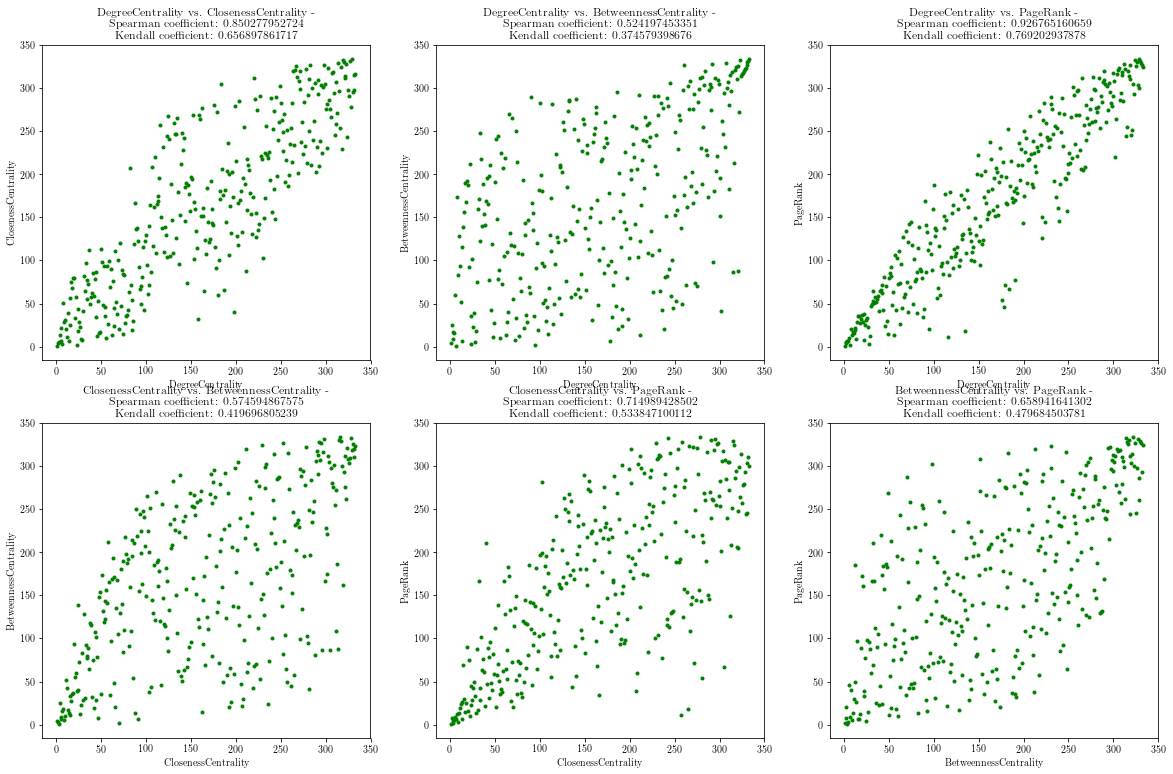

In [121]:
scores = {'DegreeCentrality': dc, 'ClosenessCentrality': cc,
          'BetweennessCentrality': bc,'PageRank': PR}
for i, j in scores.items():
    score_ranking_dict = {key: rank for rank, key in enumerate(sorted(j, key = j.get, reverse=True), 1)}
    nx.set_node_attributes(G, i, j)
    nx.set_node_attributes(G, i+'Rank', score_ranking_dict)
    
def compare_metrics(first_score, second_score):
    first_score_ranking = list(nx.get_node_attributes(G, first_score+'Rank').values())
    second_score_ranking = list(nx.get_node_attributes(G, second_score+'Rank').values())
    plt.plot(first_score_ranking, second_score_ranking, 'g.')
    plt.title('{} vs. {} -\
    \nSpearman coefficient: {}\
    \nKendall coefficient: {}'.format(first_score, second_score,
                                                       str(scipy.stats.stats.spearmanr(first_score_ranking,
                                                                                       second_score_ranking)[0]),
                                                       str(scipy.stats.stats.kendalltau(first_score_ranking,
                                                                                        second_score_ranking)[0])))
    plt.xlabel(first_score)
    plt.ylabel(second_score)

plt.figure(figsize=(20,7))

plt.subplot(4,3,1)
compare_metrics('DegreeCentrality', 'ClosenessCentrality')
plt.subplot(4,3,2)
compare_metrics('DegreeCentrality', 'BetweennessCentrality')
plt.subplot(4,3,3)
compare_metrics('DegreeCentrality', 'PageRank')
plt.subplot(4,3,4)
compare_metrics('ClosenessCentrality', 'BetweennessCentrality')
plt.subplot(4,3,5)
compare_metrics('ClosenessCentrality', 'PageRank')
plt.subplot(4,3,6)
compare_metrics('BetweennessCentrality', 'PageRank')

plt.subplots_adjust(top = 3)

We observe a strong monotonic interdependence between metrics. <br \>
The strongest correlation is between PageRank and Degree centrality rankings.<br \>
The weakest correlation - between betweenness centrality and degree centrality rankings.

## Assortative mixing

Assortativity is a preference of node to link to other nodes that are similar. 

In [126]:
degree_assort = nx.degree_assortativity_coefficient(G)
print('Node degree assortativity: {}'.format(degree_assort))

Node degree assortativity: 0.40997988781485345


In [128]:
# City
modularity_city = nx.attribute_assortativity_coefficient(G, 'cities')
print('Assortativity coefficient (modularity) for {}: {}'.format('cities', modularity_city))

Assortativity coefficient (modularity) for cities: 0.12070939738502925


In [129]:
modularity_friends = nx.attribute_assortativity_coefficient(G, 'num_friends')
print('Assortativity coefficient (modularity) for {}: {}'.format('num_friends', modularity_friends))

Assortativity coefficient (modularity) for num_friends: nan


/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:262: RuntimeWarning: invalid value encountered in true_divide
  r=(t-s)/(1-s)


At mixing by node degree, we get a value (0.41) which can be interpreted as tendency of network to be assortative. 
When assortativity coefficient equals to 1, the network is said to have perfect assortative mixing patterns, when coefficient is 0 the network is non-assortative, at value of −1 the network is completely disassortative.
From assortativity coefficient for city we can observe that our network is non-assortative by city.

### Structural similarity

In [ ]:
# For connected sub_graph
A = nx.to_numpy_matrix(, dtype=int)
A = np.asarray(A)

def plot_distance(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')

plot_distance(A)

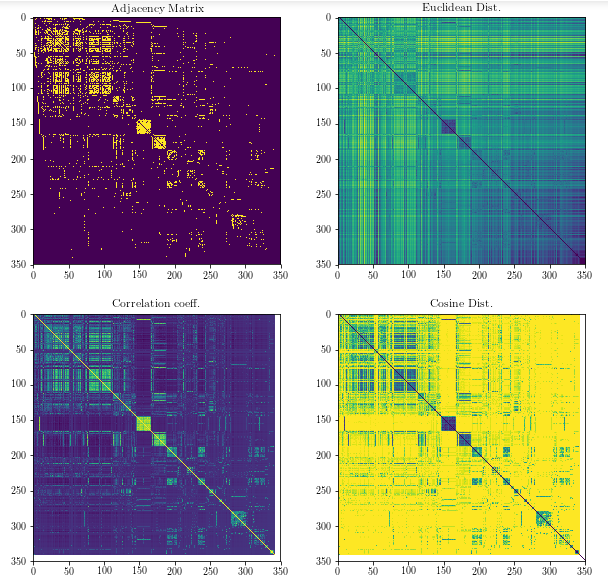

In [137]:
from IPython.display import Image
Image('structural_similarity.png')

In [ ]:
NameToNum = {}
for i in range(len(sub_graph.nodes())):
    NameToNum[sub_graph.nodes()[i]] = i

# run procedure
cm = nx.utils.reverse_cuthill_mckee_ordering(sub_graph)
# permutation
l = [NameToNum[n] for n in cm]
# reordering
A = A[np.ix_(l,l)]

plotDist(A)
plt.savefig('StrucSimilarity.png', dpi = 300)

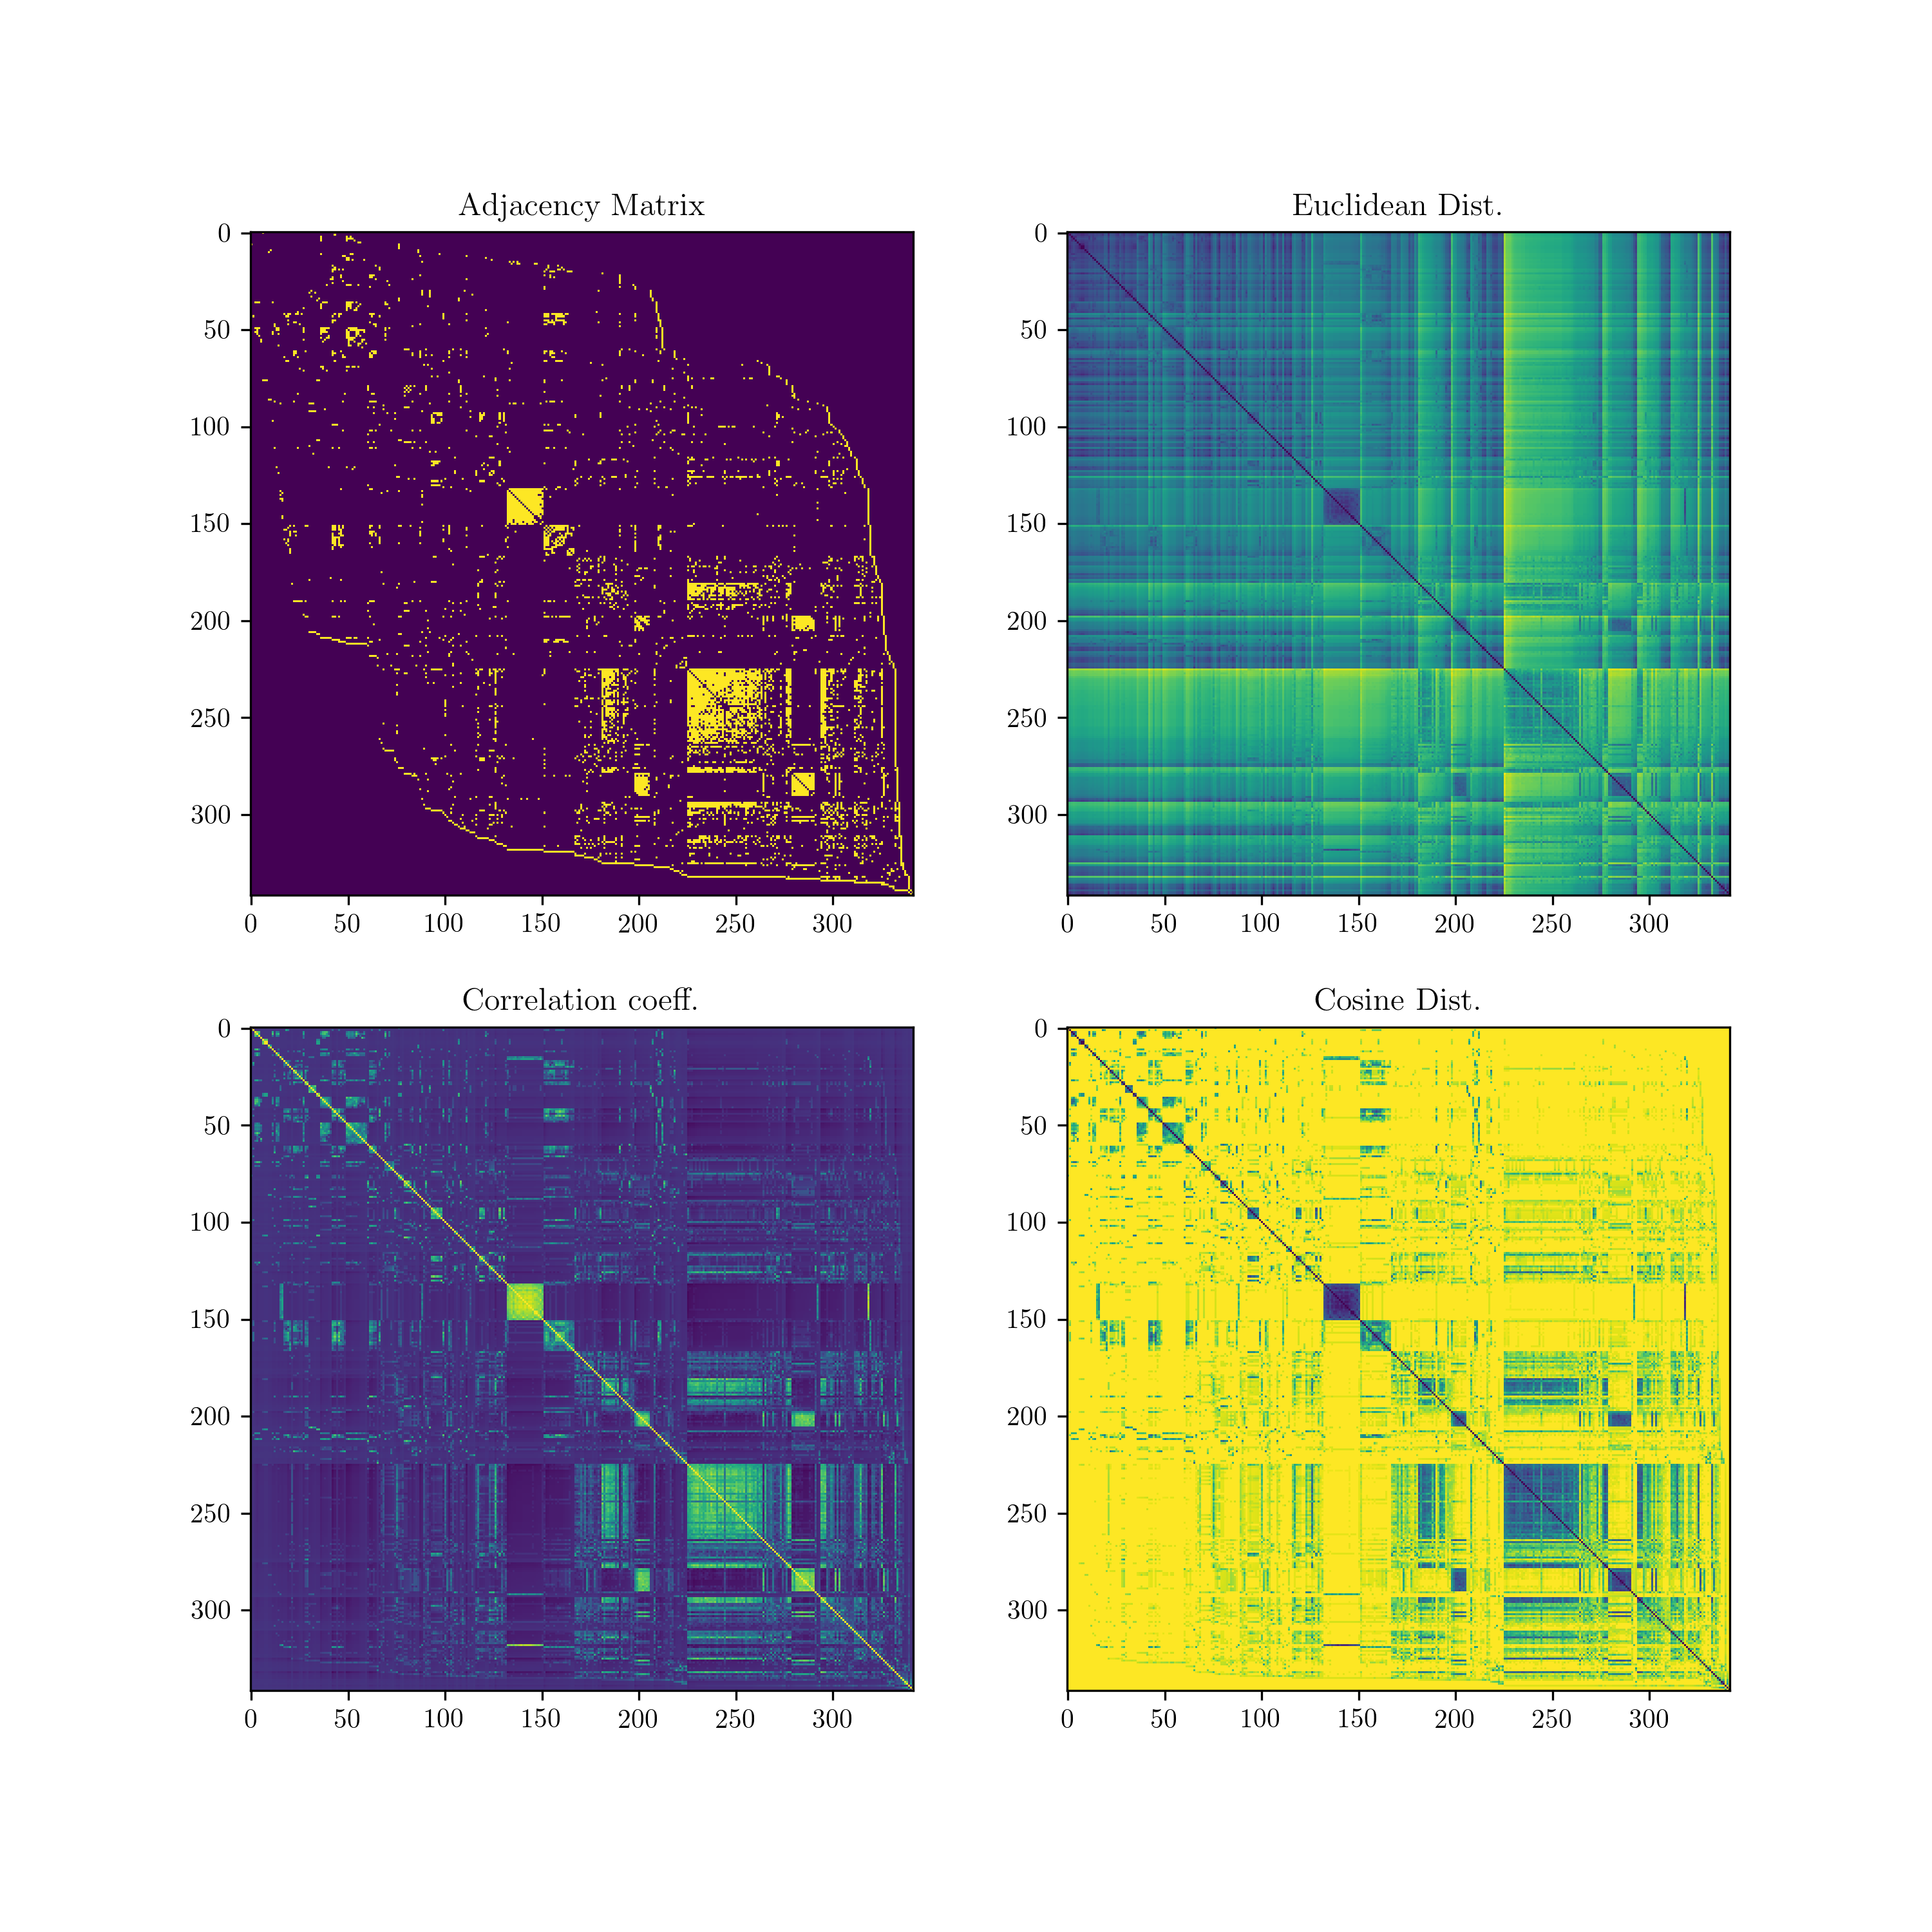

In [139]:
from IPython.display import Image
Image('InverseStrucSimilarity.png')

## Closest random graph to the network

In [144]:
def sort_degree(G):
    deg = np.array(list(G.degree().values()))
    nam = G.nodes()
    arr = np.array([deg, nam])
    return arr[1,np.argsort(deg)][::-1]

def add(n, p, lam, num):
    G = nx.Graph()     
    for i in range(n):
        G.add_node(i)
        if np.random.rand() > p:
            candidates = sort_degree(G)
            m = round(np.random.exponential(lam)*num)
            if np.random.rand() > 0.5:
                chosen = candidates[:m]
            else:
                chosen = candidates[m:3*m]
        else:
            candidates = np.arange(0,i)
            np.random.shuffle(candidates)
            m = round(np.random.exponential(lam)*num)
            chosen = candidates[:m]

        G.add_edges_from([(x, i) for x in chosen])
    return G

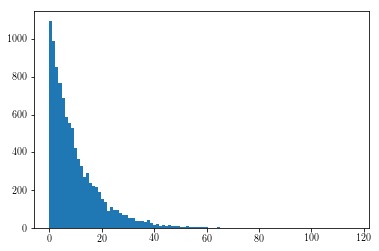

In [145]:
array = []
for i in range(10000):
    array.append(np.random.exponential(0.5)*20)
plt.hist(array, bins=100)
plt.show()

In [ ]:
GA = add(n = len(sub_graph, p = 0.8, lam = 0.08, num = 220)
kGA = list(GA.degree().values())
print('RANDOM GRAPH')
print('Mean = ', np.mean(kGA))
print('Variance = ', np.var(kGA))
print('Skewness = ', scipy.stats.skew(kGA))
print('Kurtosis = ', scipy.stats.kurtosis(kGA))

size = len(kGA)
x = scipy.arange(size)
plt.hist(kGA, bins=100, color='w')
plt.xlabel('Node degree')
plt.ylabel('PDF')
plt.savefig('RandomGraph.png', dpi = 300)
plt.show()

print('REAL GRAPH')
print('Mean = ', np.mean(kG))
print('Variance = ', np.var(kG))
print('Skewness = ', scipy.stats.skew(kG))
print('Kurtosis = ', scipy.stats.kurtosis(kG))

size = len(kG)
x = scipy.arange(size)
plt.hist(kG, bins=100, color='w')
plt.xlabel('Node degree')
plt.ylabel('PDF')
plt.savefig('RealGraph.png', dpi = 300)
plt.show()


ks_2samp(kG, kGA)

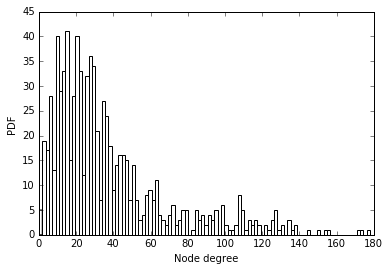

In [10]:
# from IPython.display import Image
# Image("random_graph.png")

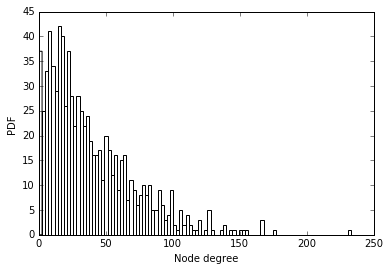

In [11]:
# from IPython.display import Image
# Image('real_graph.png')

In [148]:
## 'VK' network attributes
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)
k = np.mean(list(G.degree().values()))

## Barabasi-Albert graph model
barbarasi = nx.barabasi_albert_graph(n, int(m/n))
## Erdos-Renyi graph model
erdos = nx.erdos_renyi_graph(n, m / float(n*(n-1)/2))
## Watts-Strogatz graph model
watts = nx.watts_strogatz_graph(n, int(k), 0.5)

data = [[m, '0,368', '2.972', '8'], 
        [nx.number_of_edges(erdos), nx.average_clustering(erdos), 
         nx.average_shortest_path_length(erdos), nx.diameter(erdos)], 
        [nx.number_of_edges(barbarasi), nx.average_clustering(barbarasi), 
         nx.average_shortest_path_length(barbarasi), nx.diameter(barbarasi)],
        [nx.number_of_edges(watts), nx.average_clustering(watts), 
         nx.average_shortest_path_length(watts), nx.diameter(watts)]]
rows = ['VK network', 'Erdos-Renyi model',
        'Barabasi-Albert model', 'Watts-Strogatz model']
columns = ['Edges', 'Clustering coefficient', 'Path length', 'Diameter']
pd.DataFrame(data, rows, columns)

## Kolmogorov-Smirnov test
# print('Kolmogorov-Smirnov test results between VK network and Erdos-Renyi model -\n {}'
#       .format(scipy.stats.ks_2samp(list(G.degree().values()), list(erdos.degree().values()))))
# print('Kolmogorov-Smirnov test results between VK network and Barabasi-Albert model -\n {}'
#       .format(scipy.stats.ks_2samp(list(G.degree().values()), list(barbarasi.degree().values()))))
# print('Kolmogorov-Smirnov test results between VK network and Watts-Strogatz model -\n {}'
#       .format(scipy.stats.ks_2samp(list(G.degree().values()), list(watts.degree().values()))))


Edges Clustering coefficient Path length Diameter
VK network              3302                  0,368       2.972        8
Erdos-Renyi model       3345              0.0560016     2.24351        3
Barabasi-Albert model   2988               0.121368     2.29162        3
Watts-Strogatz model    3069               0.115805     2.36942        4

## Clique search

In [ ]:
cliques = list(nx.find_cliques(G))
length_clique = [len(x) for x in cliques]
plt.hist(LenCliq, bins=40, color='w')
plt.xlabel('Nodes in clique')
plt.ylabel('Instances')

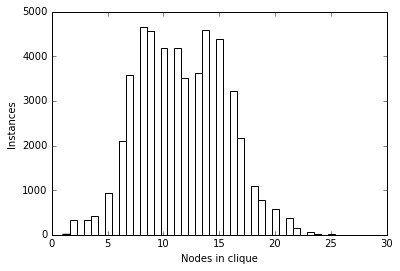

In [159]:
from IPython.display import Image
Image('clique_search.png')

In [160]:
# Maximum size of a clique
max_clique = np.argmax(length_clique )
max_clique

1622

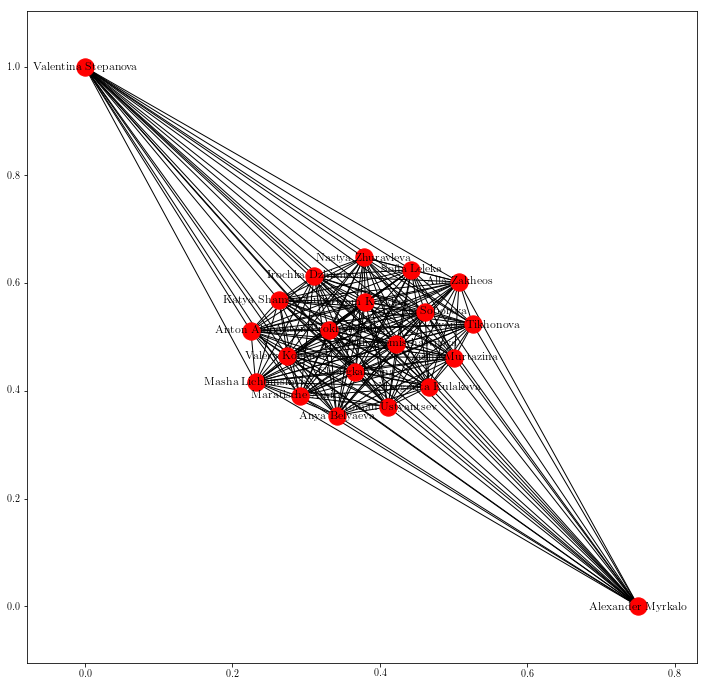

In [162]:
len(cliques[max_clique])
plt.figure(figsize=(12,12))
nx.draw_networkx(G.subgraph(cliques[max_clique]), with_labels=True)

## Community Detection (by greedy optimization of modularity)

This function implements the fast greedy modularity optimization algorithm for finding community structure <br \> (Reference: A Clauset, MEJ Newman, C Moore: Finding community structure in very large networks, http://www.arxiv.org/abs/cond-mat/040818) 

In [164]:
import igraph as ig

nx.write_gml(sub_graph, 'G_connected.gml')
iG = ig.read('G_connected.gml')
communities = ig.Graph.community_fastgreedy(iG)
clusters = communities.as_clustering()

In [ ]:
# communities = ig.community_edge_betweenness(iG, directed=False)
# communities_2 = ig.community_multilevel(iG)
# communities_3 = ig.community_label_propagation(iG)
# communities_4 = ig.community_leading_eigenvector(iG)
# communities_5 = ig.community_optimal_modularity(iG)
# communities_6 = ig.community_edge_betweenness(iG)

In [165]:
clss = [[] for i in range(len(clusters))]
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        clss[i].append(list(sub_graph.nodes())[clusters[i][j]])
clss

[['Mityay Romanenko',
  'Olya Krim',
  'Sofya Tagunova',
  'Valeria Shalaeva',
  'Armen Esayan',
  'Malika Tuychieva',
  'Diana Demeshkina',
  'Anna Reingold',
  'Polina Ananyeva',
  'Toma Filippova',
  'Darya Petrishina',
  'Lilia Kirdyanova',
  'Daniela Roginskaya',
  'Polinka Ananyeva',
  'Vasilisa Zix',
  'Lena Veryatina',
  'Anna Ganeeva',
  'Yulia Sharabasheva',
  'Elmira Ismanova',
  'Darya Demekhina',
  'Alina Sharabasheva',
  'Ksenia Sankovich',
  'Nastasia Produvnova',
  'Sonyushka Mikhaylenko',
  'Anastasia Makhonina',
  'Nastya Sheve',
  'Ignat Goldman',
  'Alyona Davydova',
  'Roman Sidorchuk',
  'Masha Kuramina',
  'Olya Lomakina',
  'Meri Petrosyan',
  'Nigina Boboeva',
  'Ksenia Kharvud',
  'Elena Snegireva',
  'Natali Korolkova',
  'Arseny Kuzikov',
  'Mikhail Khrabrov',
  'Gelya Levchenko',
  'Ksenia Kokorina',
  'Kirill Alert',
  'Zakhar Semenov',
  'Yury Konstantinov',
  'Sergey Khripkov',
  'Innka Mironova',
  'Dmitry Lazutin',
  'Natalya Korolkova',
  'Sergey Kach

* **First community**: 
HSE different departments + HSE professors + I like trip HSE  + some of my close friends from HSE and the same affiliation groups. 

* **Second community**: 
School 1215 + two different classes + elder fellows + our mutual friends

* **Third community**: 
HSE Political Science department 

* **Fourth community**: 
AstraZeneca (collegues)

* **Fifth community**: 
HSE Spb group (Big data analysis)

* **Sixth community**: 
AIESIC 

* **Seventh community**: 
TNS (internship)

In [168]:
s = 0
for x in clss:
    s += len(x)
len(sub_graph.nodes()), s

(333, 333)

In [171]:
col = ['#ff5e3a', '#ff2a68', '#0bd318', '#5ac8fb', '#1c86ee', '#5856d6', '#2b2b2b']
color = []
i = 0
for x in clss:
    print(len(x))
    color.append([col[i] for d in x])
    i += 1

72
112
51
35
36
16
11


In [174]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.fruchterman_reingold_layout(sub_graph)

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

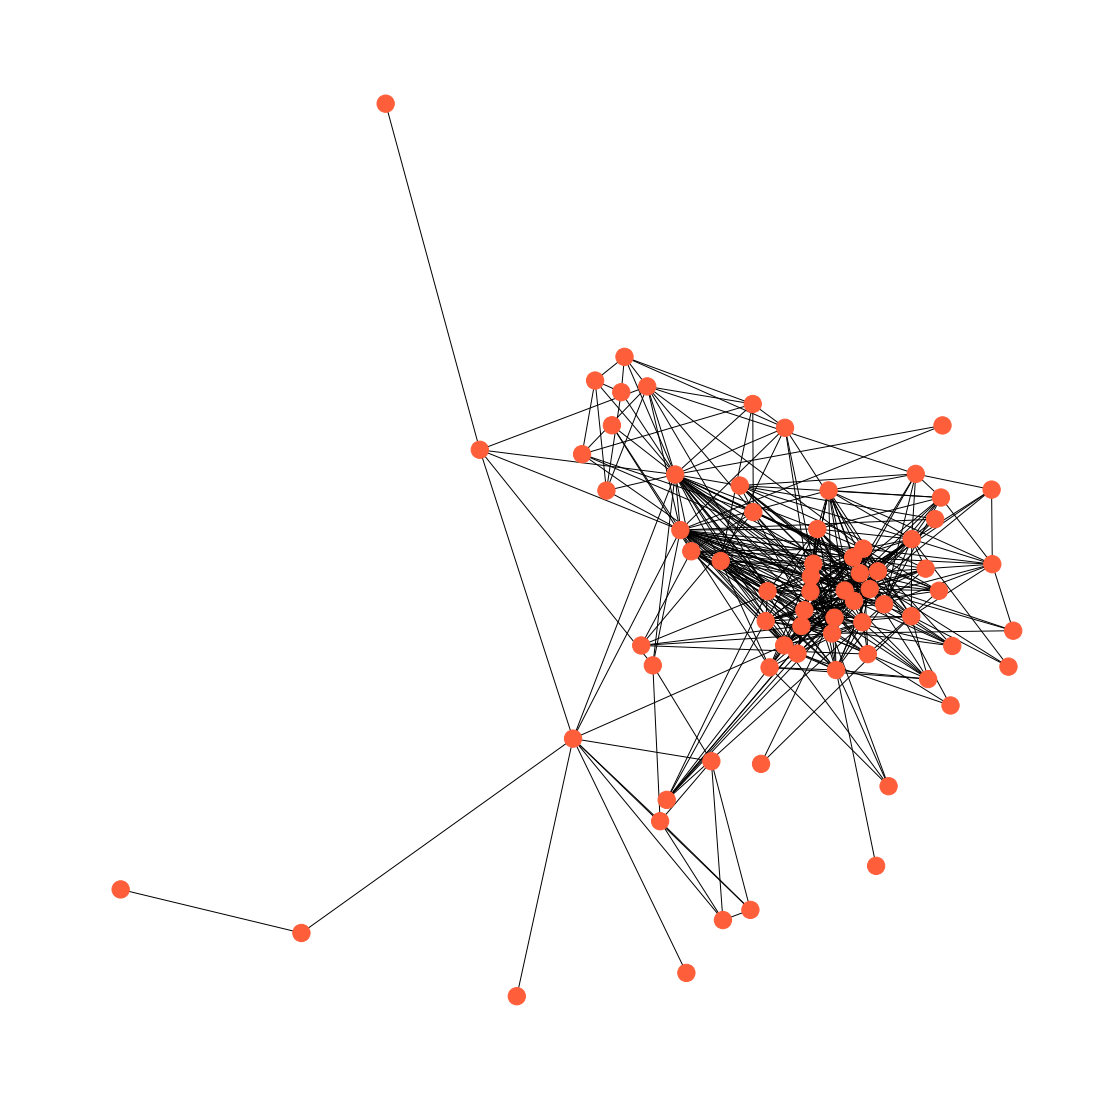

In [176]:
#import seaborn
plt.figure(figsize=(15,15))

nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
plt.savefig('cluster0.png', dpi = 300)
#clss[0]
# School 1215

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

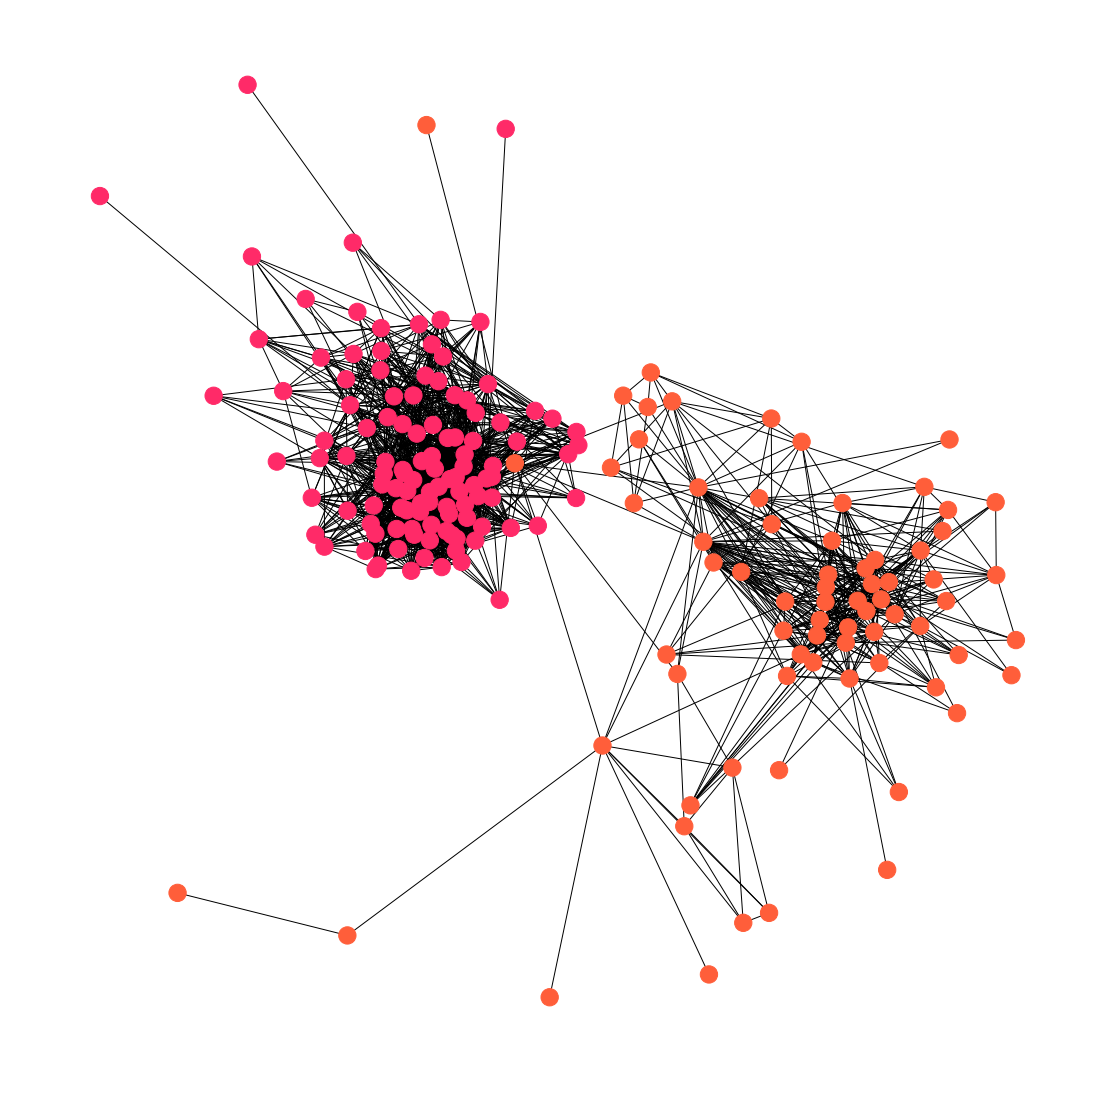

In [177]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
#clss[1]
# HSE 'I like trip' club + friends from other HSE departments + athletics

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

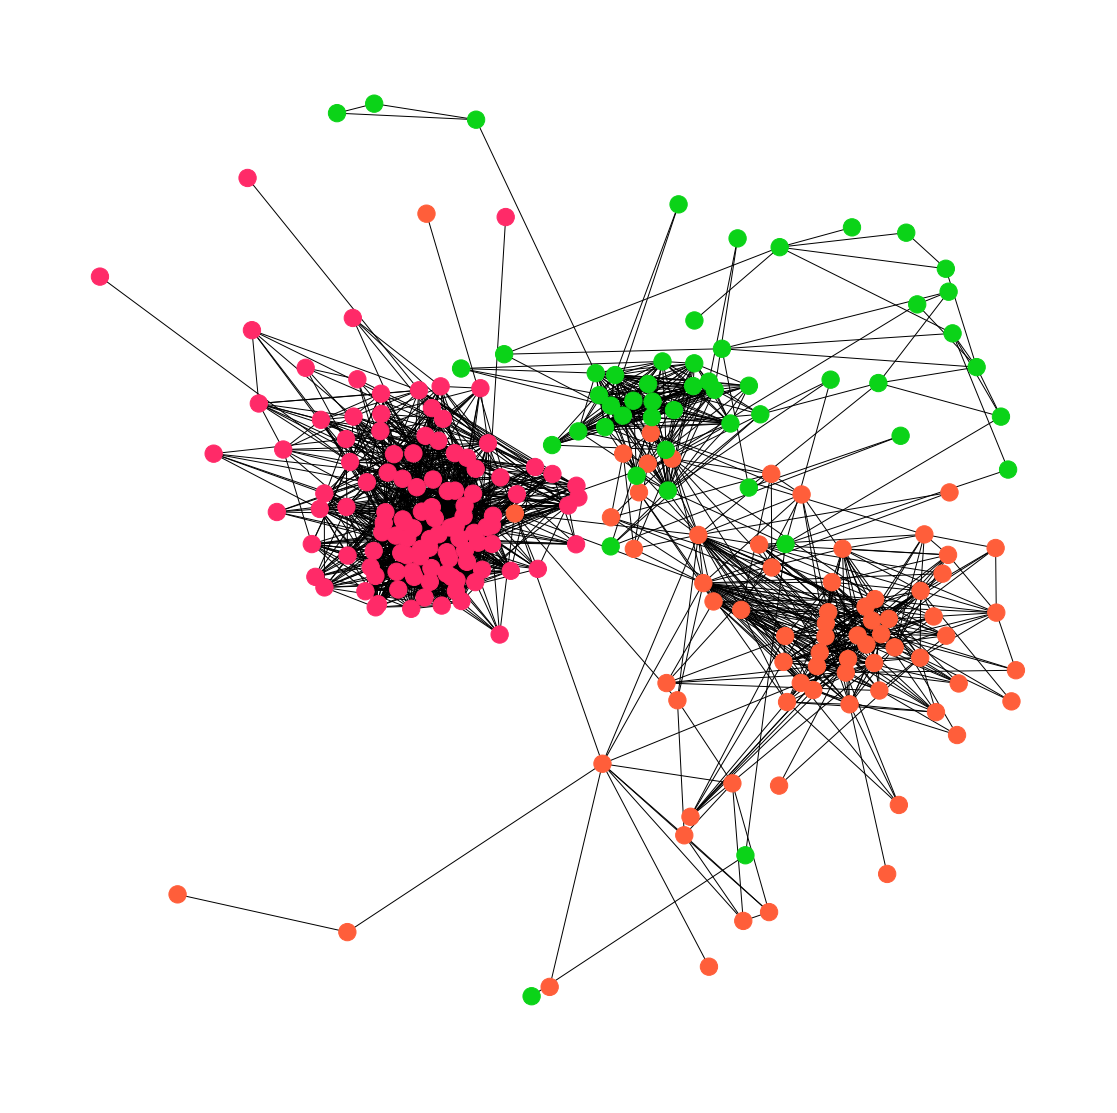

In [178]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
nx.draw(sub_graph.subgraph(clss[2]), node_color = color[2], pos=pos)
#clss[2]
# HSE political scientists 

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

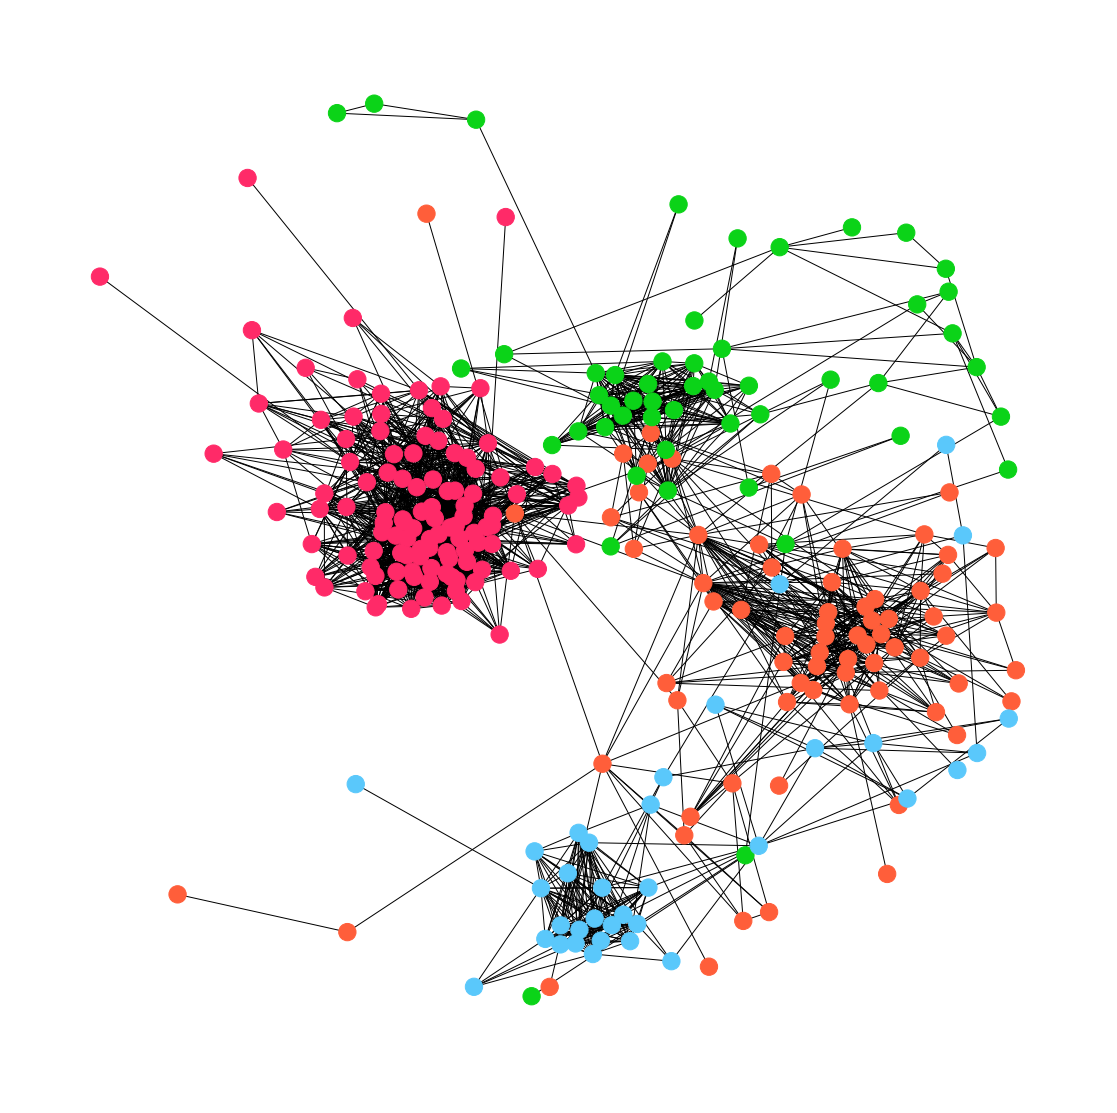

In [179]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
nx.draw(sub_graph.subgraph(clss[2]), node_color = color[2], pos=pos)
nx.draw(sub_graph.subgraph(clss[3]), node_color = color[3], pos=pos)
#clss[3]
# AstraZeneca

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

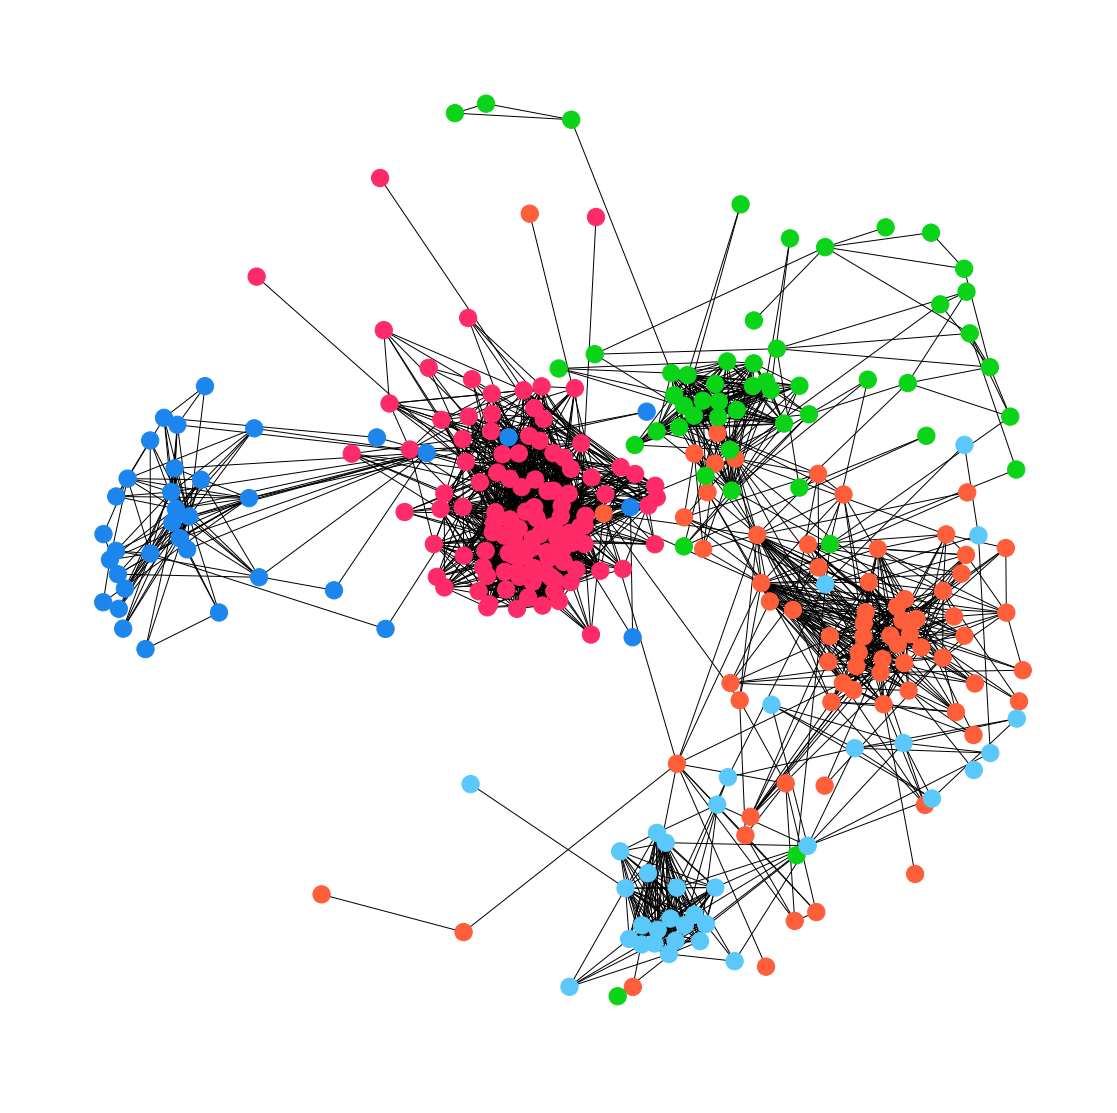

In [180]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
nx.draw(sub_graph.subgraph(clss[2]), node_color = color[2], pos=pos)
nx.draw(sub_graph.subgraph(clss[3]), node_color = color[3], pos=pos)
nx.draw(sub_graph.subgraph(clss[4]), node_color = color[4], pos=pos)
#clss[4]
# MBD 161

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

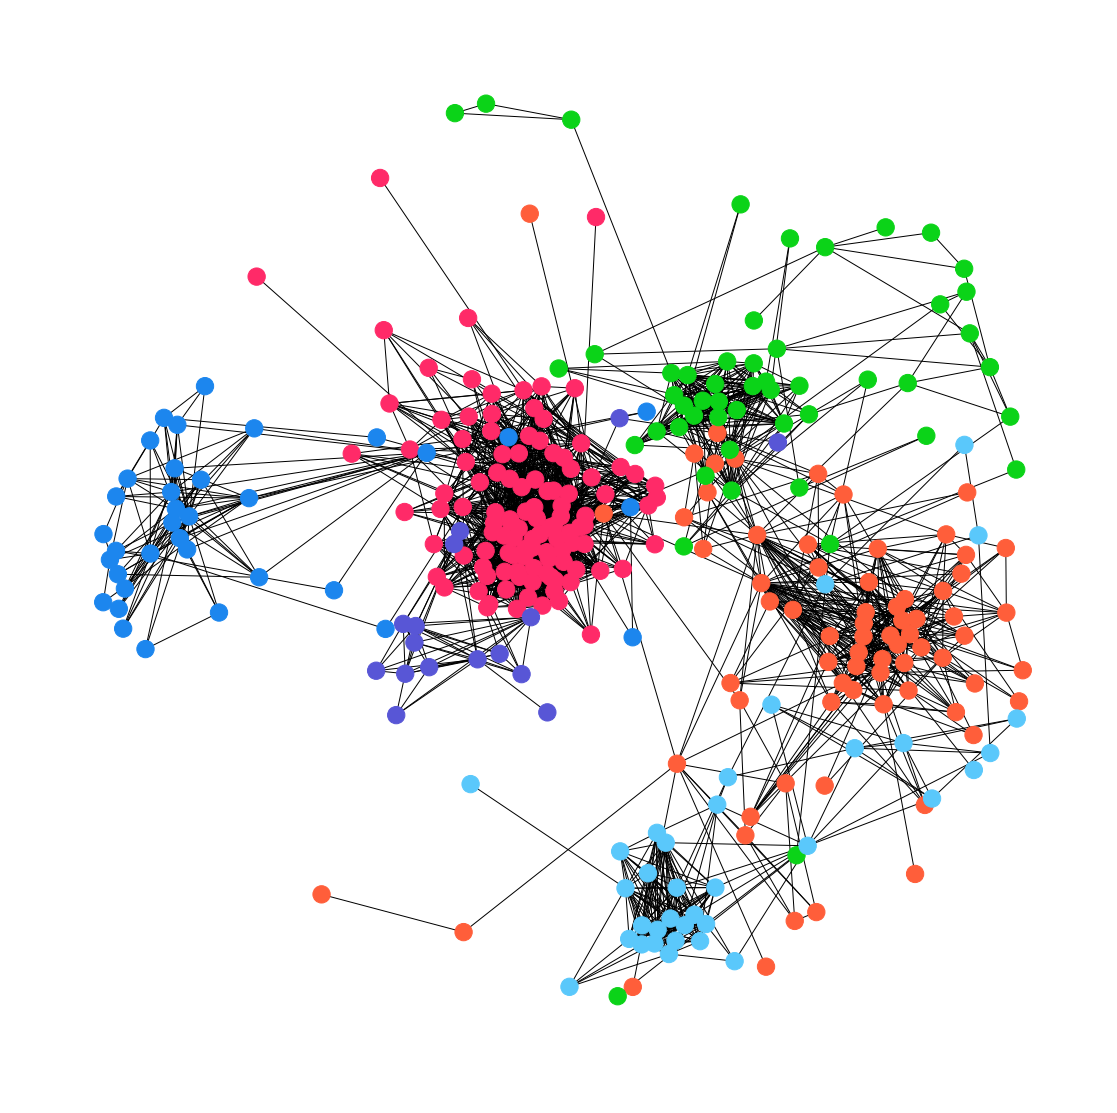

In [181]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
nx.draw(sub_graph.subgraph(clss[2]), node_color = color[2], pos=pos)
nx.draw(sub_graph.subgraph(clss[3]), node_color = color[3], pos=pos)
nx.draw(sub_graph.subgraph(clss[4]), node_color = color[4], pos=pos)
nx.draw(sub_graph.subgraph(clss[5]), node_color = color[5], pos=pos)
#clss[5]
# Anticcoruption school participants + human rights activists

/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MarinaAnanyeva/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

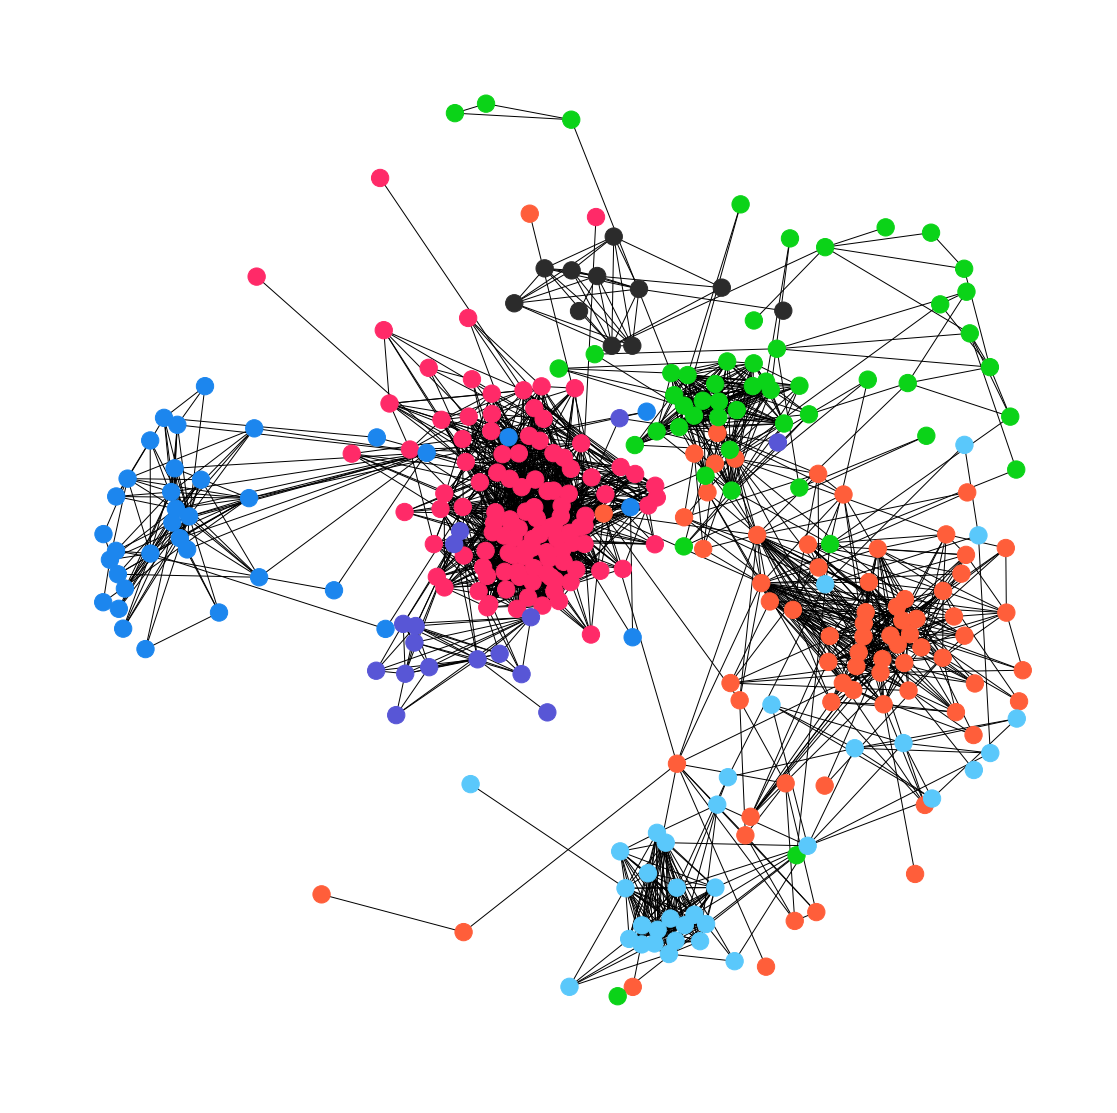

In [182]:
plt.figure(figsize=(15,15))
nx.draw(sub_graph.subgraph(clss[0]), node_color = color[0], pos=pos)
nx.draw(sub_graph.subgraph(clss[1]), node_color = color[1], pos=pos)
nx.draw(sub_graph.subgraph(clss[2]), node_color = color[2], pos=pos)
nx.draw(sub_graph.subgraph(clss[3]), node_color = color[3], pos=pos)
nx.draw(sub_graph.subgraph(clss[4]), node_color = color[4], pos=pos)
nx.draw(sub_graph.subgraph(clss[5]), node_color = color[5], pos=pos)
nx.draw(sub_graph.subgraph(clss[6]), node_color = color[6], pos=pos)
#clss[6]
# TNS Russia (internship)

Summing up, we have identified 7 communities and visualized them step by step. 
However, other algorithms (like Label propogation, k-clique, etc) should also be tested, but this greedy algorithm is regarded as one of the best among them. 

<r \>

# <center> Thank you! <center>